In [1]:
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt


In [48]:
a = pk.load(open("/home/opisthofulax/PhD/projects/complex-networks/lrgsglib/data/l2d_squared/spect/N=1024/dist1_0.1_scipy_1000.pkl", "rb"))

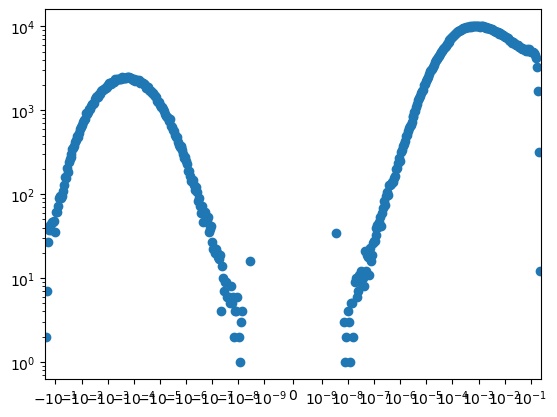

In [49]:
plt.plot(list(a[0].keys()), list(a[0].values()), 'o')
plt.yscale('log')
plt.xscale('symlog', linthresh=10**(-9))

In [2]:
def process_data(a):
    arr = np.column_stack([list(a.keys()), list(a.values())])
    arr = arr[np.argsort(arr[:, 0])]
    return arr
def coarse_grain(arr, n=10):
    length = len(arr) // n * n
    arr_truncated = arr[:length]
    arr_reshaped = arr_truncated.reshape(-1, n, arr.shape[1])
    arr_coarse = arr_reshaped.mean(axis=1)
    return arr_coarse

In [35]:
a1 = pk.load(open("/home/opisthofulax/PhD/projects/complex-networks/lrgsglib/data/l2d_squared/spect/N=100/dist_eigval_0.1_rand_1000.pkl", "rb"))
arr1 = process_data(a1)
arr1_coarse = coarse_grain(arr1, 10)
a2 = pk.load(open("/home/opisthofulax/PhD/projects/complex-networks/lrgsglib/data/l2d_squared/spect/N=4096/dist_eigval_0.1_rand_100.pkl", "rb"))
arr2 = process_data(a2)
arr2_coarse = coarse_grain(arr2, 10)
a3 = pk.load(open("/home/opisthofulax/PhD/projects/complex-networks/lrgsglib/data/l2d_squared/spect/N=1024/dist_eigval_0.1_rand_1000.pkl", "rb"))
arr3 = process_data(a3)
arr3_coarse = coarse_grain(arr3, 10)

FileNotFoundError: [Errno 2] No such file or directory: '/home/opisthofulax/PhD/projects/complex-networks/lrgsglib/data/l2d_squared/spect/N=100/dist_eigval_0.1_rand_1000.pkl'

In [36]:
avg_spacing = np.mean(np.diff(np.sort(arr1[:,0])))
bar_width = avg_spacing

<BarContainer object of 4975 artists>

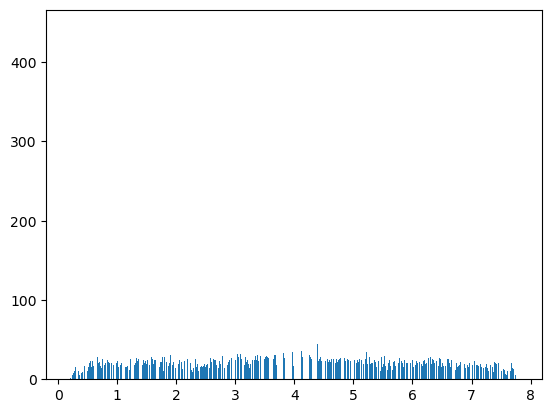

In [34]:
plt.bar(arr1[:, 0], arr1[:, 1], width=bar_width)
# plt.plot(arr1_coarse[:, 0], arr1_coarse[:, 1], '-')
# plt.yscale('log')
# plt.xscale('log')

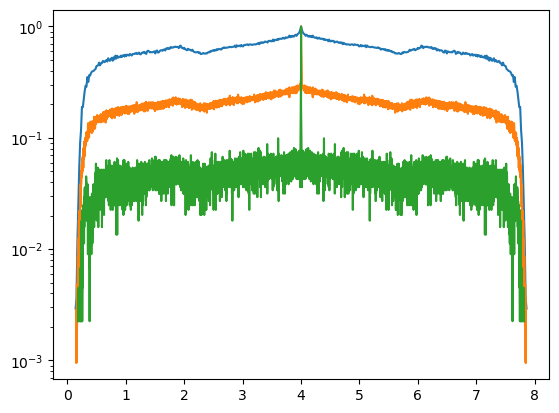

In [98]:

plt.plot(arr2[:,0], arr2[:,1]/np.max(arr2[:,1]), '-')
plt.plot(arr3[:,0], arr3[:,1]/np.max(arr3[:,1]), '-')
plt.plot(arr1[:,0], arr1[:,1]/np.max(arr1[:,1]), '-')

# plt.plot(arr2_coarse[:, 0], arr2_coarse[:, 1], '-')
plt.yscale('log')

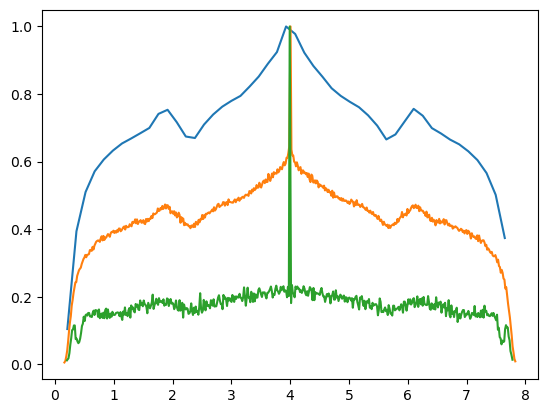

In [100]:

# Function to reduce binning
def reduce_bins(arr, bin_factor):
    # Reshape the data to aggregate adjacent bins, then compute the mean
    reduced_bins = arr[:len(arr) - len(arr) % bin_factor].reshape(-1, bin_factor, 2)
    return np.mean(reduced_bins, axis=1)

# Reduce the binning for each dataset by a factor of 2
bin_factor = 10  # Adjust this to change how much you reduce the binning
arr1_reduced = reduce_bins(arr1, bin_factor)
arr2_reduced = reduce_bins(arr2, bin_factor)
arr3_reduced = reduce_bins(arr3, bin_factor)

# Plotting the reduced data
plt.plot(arr2_reduced[:, 0], arr2_reduced[:, 1] / np.max(arr2_reduced[:, 1]), '-')
plt.plot(arr3_reduced[:, 0], arr3_reduced[:, 1] / np.max(arr3_reduced[:, 1]), '-')
plt.plot(arr1_reduced[:, 0], arr1_reduced[:, 1] / np.max(arr1_reduced[:, 1]), '-')
plt.show()

In [80]:
np.min(arr1[:,0]), np.min(arr2[:,0]), np.max(arr1[:,0]), np.max(arr2[:,0])

(0.1828384720635507, 0.1510594086111195, 7.817161527936452, 7.848940591388881)

In [81]:
np.max(arr2[:,0])/np.min(arr2[:,0]), np.max(arr1[:,0])/np.min(arr1[:,0])

(51.9592964354497, 42.754467589399766)

In [82]:
arr2[0,0]

0.1510594086111195